In [461]:
import util, scrape

import collections
import itertools
import re
import pickle
import csv
import multiprocessing

from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
import scipy 
import nltk
import gensim
import string
import spacy

In [484]:
import importlib
util = importlib.reload(util)
scrape = importlib.reload(scrape)

In [4]:
MIN_NUM_TRIP_REPORTS = 25

df = pd.read_csv(util.TRIP_REPORTS_FILE)

drug_to_trip_reports_count_dict = dict(sorted(collections.Counter(df["drug"]).items(), key=lambda x: x[1]))
drugs_to_ignore = [drug for drug, count in drug_to_trip_reports_count_dict.items() if count < MIN_NUM_TRIP_REPORTS]

for drug_to_ignore in drugs_to_ignore:
    df = df[df.drug != drug_to_ignore]
    
df = df.sample(frac=1)
df.reset_index(inplace=True, drop=True)

In [5]:
df

,drug,trip_report
0,4HOMiPT,A friend recently told me of this experience ...
1,DMT,I think some people are naturally more prone t...
2,Mushrooms,I was fourteen when I had my first experience ...
3,Salvia_divinorum,Before you are the events of my second encount...
4,25CNBOMe,T 0;00 150mgs mdma 400ug 25c-NBOMe T 1;00...
...,...,...
5365,4AcODET,4:00 Set up well for an experience. Home is ...
5366,25INBOMe,"This won't be the best report, as I can't real..."
5367,Mushrooms,I shall take a moment to introduce a prelimina...
5368,Salvia_divinorum,Trip 1 - Mushrooms & Salvia lvl 4 I had ju...


In [6]:
def get_drug_to_phrase_relative_frequency_dict(phrase):
    drug_to_count_dict = collections.defaultdict(int)
    drug_to_phrase_frequency_dict = collections.defaultdict(int)
    for i, trip_report in enumerate(df["trip_report"]):
        drug_to_count_dict[df["drug"][i]] += 1
        if phrase in trip_report:
            drug_to_phrase_frequency_dict[df["drug"][i]] += 1
    
    phrase_relative_frequency_dict = {drug : round(float(drug_to_phrase_frequency_dict[drug] / drug_to_count_dict[drug]), 2) for drug in drug_to_count_dict.keys()}
    
    return phrase_relative_frequency_dict


In [102]:
def preprocess(text):
    # remove square brackets and their contents (messages left by erowid administrators)
    brackets = re.findall(re.compile("\(.*?\)"), text)
    for b in brackets:
        names_text = text.replace(b, " ")
    
    # remove zero-width space 
    text = text.replace("\u200b", " ")
    
    return text

class EntityRetokenizeComponent:
    def __init__(self, pipeline):
        pass
    
    def __call__(self, doc):
        with doc.retokenize() as retokenizer:
            for ent in doc.ents:
                retokenizer.merge(doc[ent.start:ent.end], attrs={"LEMMA": str(doc[ent.start:ent.end])})
        return doc

spacy_pipeline = spacy.load('en')
retokenizer = EntityRetokenizeComponent(spacy_pipeline) 
spacy_pipeline.add_pipe(retokenizer, name='merge_enitities', last=True)
    
df["trip_report_preprocessed"] = df["trip_report"].progress_apply(preprocess)

df["trip_report_spacy"] = df["trip_report_preprocessed"].progress_apply(spacy_pipeline)

In [224]:
df["trip_report_spacy"][100].doc.ents


(LSD,
 ten years,
 A few months ago,
 ten years old,
 Marla,
 Fight Club,
 one,
 LSD,
 fifth,
 Beatles,
 twenty-one,
 one,
 the next day,
 ten-year-old's,
 just a few hours,
 SEE,
 eleven years,
 third,
 LSD,
 first,
 three,
 second,
 one,
 third,
 two,
 LSD,
 about 12:15 on the night,
 the next day,
 12:30,
 two,
 the night,
 about half an hour,
 'Team America,
 an hour,
 Kate,
 30-minute,
 hours,
 1:45 am,
 first,
 ON,
 K's,
 K,
 3-D.,
 ~really~,
 one,
 about an hour,
 summer,
 night,
 first,
 Weezer,
 Eileen,
 Crystal Method,
 Persia,
 several hours,
 one,
 7-11,
 Nada Surf,
 that night,
 7-11,
 7,
 Persia,
 between 10 and 11 am,
 night,
 those few days,
 the twelfth hour,
 The next day,
 the day,
 the day,
 SEE,
 eleven years,
 LSD)

In [33]:
dir(df["trip_report_spacy"][0].doc[0])

['_',
 '__bytes__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 'ancestors',
 'check_flag',
 'children',
 'cluster',
 'conjuncts',
 'dep',
 'dep_',
 'doc',
 'ent_id',
 'ent_id_',
 'ent_iob',
 'ent_iob_',
 'ent_type',
 'ent_type_',
 'get_extension',
 'has_extension',
 'has_vector',
 'head',
 'i',
 'idx',
 'is_alpha',
 'is_ancestor',
 'is_ascii',
 'is_bracket',
 'is_currency',
 'is_digit',
 'is_left_punct',
 'is_lower',
 'is_oov',
 'is_punct',
 'is_quote',
 'is_right_punct',
 'is_sent_start',
 'is_space',
 'is_stop',
 'is_title',
 'is_upper',
 'lang',
 'lang_',
 'left_edge',
 'lefts',
 'lemma',
 'lemma_',
 'lex_id',
 'like_email',
 'like_num',
 'l

In [494]:
custom_stop_words = scrape.get_custom_stop_words()

with open(util.CUSTOM_STOP_WORDS_FILE, "wb") as f:
    pickle.dump(custom_stop_words, f)

In [495]:
custom_stop_words = set(util.unpickle(util.CUSTOM_STOP_WORDS_FILE))


In [747]:
def tokenize(doc):
    tokens = []
    for w in doc.doc:
        if all([
            (w.is_alpha),
            (w.lang_ == 'en'),
            (w.is_ascii),
            (not spacy_pipeline.vocab[w.text.lower()].is_stop),
            (w.text.lower() not in custom_stop_words),
            (w.lemma_ not in custom_stop_words),
            (not w.is_space), 
            (not w.is_punct),
            (not w.is_digit),
            (w.ent_type == 0)
        ]):
            tokens.append(str(w.lemma_))
    return tokens


In [845]:
tokenized = df["trip_report_spacy"].progress_apply(tokenize)

MIN_WORD_COUNT = 20

vocabulary = []
for tokens in tokenized:
    vocabulary += tokens
word_count_dict = dict(sorted(collections.Counter(vocabulary).items(), key=lambda x: x[1], reverse=True))
vocabulary = set([w for w in word_count_dict if word_count_dict[w] >= MIN_WORD_COUNT])

def filter_uncommon_words(tokens):
    return [str(token) for token in tokens if token in vocabulary]

df["trip_report_tokenized"] = tokenized.progress_apply(filter_uncommon_words)

In [748]:
len(vocabulary)

5368

In [732]:
df["trip_report_tokenized"]


0       [friend, recently, tell, experience, estimate,...
1       [think, people, naturally, prone, contact, ent...
2       [experience, magic, old, sister, substance, ge...
3       [event, second, encounter, hear, awakening, re...
4       [beer, beer, pot, background, try, countless, ...
                              ...                        
5365    [set, experience, home, clean, organize, rest,...
5366    [will, good, report, remember, happen, visuall...
5367    [shall, moment, introduce, story, proceed, ori...
5368    [trip, return, fair, couple, close, friend, gr...
5369    [buy, morning, heavenly, blue, gate, research,...
Name: trip_report_tokenized, Length: 5370, dtype: object

In [1258]:
X = [gensim.models.doc2vec.TaggedDocument(words=trip_report_tokenized, tags=[u"DOC_%s" % i]) for i, trip_report_tokenized in enumerate(df["trip_report_tokenized"])] 

    

In [1259]:
VECTOR_SIZE = 256
WINDOW = 4
LR = 0.025
LR_MIN = 0.025
LR_STEP = 0.002

In [1260]:
def train_model(model, X, num_epochs):
    for epoch in range(1, num_epochs+1):
        print(f"Epoch: {epoch}")
        model.train(X, total_examples=model.corpus_count, epochs=model.epochs)
        model.alpha -= LR_STEP  # decrease the learning rate
        model.min_alpha = LR_MIN

In [1261]:
model = gensim.models.doc2vec.Doc2Vec(X, workers=multiprocessing.cpu_count(), dm=1, size=VECTOR_SIZE, window=WINDOW, alpha=LR, min_alpha=LR_MIN)  




/Users/ianscottknight/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [1262]:
train_model(model, X, num_epochs=20)


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20


In [1266]:
# get average doc vec
avg_doc_vec = np.mean([model.docvecs[i] for i in range(len(model.docvecs))], axis=0)

# accumalte doc vecs for each drug in a dictionary
drug_to_doc_vecs_dict = collections.defaultdict(list)
for i in range(len(model.docvecs)):
    doc_tag = f"DOC_{i}"
    drug = get_drug_from_doc_tag(doc_tag)
    doc_vec = model.docvecs[doc_tag]
    drug_to_doc_vecs_dict[drug].append(doc_vec)
    
# assign a psych vec for each psychedelic by taking adding the difference between the mean of the drug's doc vecs 
# and the average doc vec to the mean of the drug's doc vecs, in order to produce a vector that is more extreme in
# the ways that the drug's average doc vec is already extreme, so as to highlight what makes it distinct from the 
# other drug's average doc vec
SIGMA = 1
drug_to_psych_vec_dict = {drug : np.mean(doc_vecs, axis=0) + ((np.mean(doc_vecs, axis=0) - avg_doc_vec) * SIGMA) for drug, doc_vecs in drug_to_doc_vecs_dict.items()}

# print the words whose vectors are closest to each psych vec
for drug, psych_vec in drug_to_psych_vec_dict.items():
    print(drug+'\n', model.wv.most_similar([psych_vec]), '\n')
    

4HOMiPT
 [('reviewer', 0.28213316202163696), ('winamp', 0.25105908513069153), ('gradual', 0.2490256428718567), ('dab', 0.23972222208976746), ('indistinct', 0.23517626523971558), ('unnoticed', 0.23442906141281128), ('effects', 0.22241315245628357), ('eyeballing', 0.22184230387210846), ('trailing', 0.220158651471138), ('pronounced', 0.21948525309562683)] 

DMT
 [('shaft', 0.2408960610628128), ('reviewer', 0.23430180549621582), ('powerless', 0.231988787651062), ('eyeballing', 0.23114576935768127), ('portal', 0.22933177649974823), ('vag', 0.22405512630939484), ('uncover', 0.2230307161808014), ('instinctively', 0.21999242901802063), ('nothingness', 0.217705637216568), ('polarity', 0.21580739319324493)] 

Mushrooms
 [('eyeballing', 0.2712293267250061), ('taco', 0.25115010142326355), ('cyanescen', 0.24105723202228546), ('reviewer', 0.23513191938400269), ('petty', 0.22774066030979156), ('senior', 0.22666803002357483), ('eighth', 0.2236962616443634), ('extremly', 0.2209431529045105), ('begining

In [1267]:
model.wv.most_similar(positive=["queen", "man"], negative=["woman"])

[('commonly', 0.24381382763385773),
 ('quality', 0.23719704151153564),
 ('psytrance', 0.22335121035575867),
 ('evil', 0.21242102980613708),
 ('popcorn', 0.20535722374916077),
 ('blah', 0.20381325483322144),
 ('bill', 0.2030932903289795),
 ('lick', 0.19241774082183838),
 ('vertical', 0.19013330340385437),
 ('saucer', 0.19007278978824615)]

In [1246]:
positive = [ drug_to_psych_vec_dict["Mushrooms"] ]
negative = [ model.wv["fun"] ]
model.wv.most_similar(positive=positive, negative=negative)

[('taco', 0.3572549819946289),
 ('tweak', 0.2910372316837311),
 ('ph', 0.28370434045791626),
 ('negatively', 0.28251397609710693),
 ('granola', 0.28226596117019653),
 ('choosing', 0.2786223590373993),
 ('til', 0.27661797404289246),
 ('spaghetti', 0.2763144373893738),
 ('achievement', 0.2709430158138275),
 ('accident', 0.26890936493873596)]

In [1249]:
vec = model.wv["dread"] 
get_drug_distances(vec)[:3]

[('Salvia_divinorum', 0.8145820498466492),
 ('5MeODMT', 0.8282520622014999),
 ('DMT', 0.8413759917020798)]

In [1155]:
vec = drug_to_psych_vec_dict["DMT"] - model.wv["elf"]
get_drug_distances(vec)[:3]

[('5MeODMT', 0.46333587169647217),
 ('DPT', 0.47005122900009155),
 ('4AcODMT', 0.5520279705524445)]

In [1250]:
positive = drug_to_psych_vec_dict["DiPT"] - model.wv["audio"] + model.wv["vision"]
get_drug_distances(vec)[:3]

[('Salvia_divinorum', 0.8145820498466492),
 ('5MeODMT', 0.8282520622014999),
 ('DMT', 0.8413759917020798)]

In [1157]:
vec = drug_to_psych_vec_dict["Mushrooms"] - model.wv["spirit"] 
get_drug_distances(vec)[:3]

[('25INBOMe', 0.25548189878463745),
 ('2CP', 0.2974596619606018),
 ('LSD', 0.31245797872543335)]

In [1158]:
vec = drug_to_psych_vec_dict["LSD"] - model.wv["spirit"] 
get_drug_distances(vec)[:3]

[('25INBOMe', 0.28415989875793457),
 ('2CP', 0.3496268391609192),
 ('LSD', 0.3522094488143921)]

In [1133]:
vec = drug_to_psych_vec_dict["Mushrooms"] + model.wv["spirit"] 
get_drug_distances(vec)[:3]

[('Mushrooms', 0.3312106728553772),
 ('DMT', 0.4306846857070923),
 ('LSD', 0.49181681871414185)]

In [1159]:
vec = drug_to_psych_vec_dict["LSD"] - model.wv["tracer"] 
get_drug_distances(vec)[:3]

[('Mushrooms', 0.8046131283044815),
 ('LSD', 0.8401806801557541),
 ('4AcODMT', 0.8790504485368729)]

In [1160]:
vec = drug_to_psych_vec_dict["Salvia_divinorum"] - model.wv["angel"] + model.wv["demon"]
get_drug_distances(vec)[:3]

[('Salvia_divinorum', 0.35803139209747314),
 ('LSD', 0.5490208268165588),
 ('Mushrooms', 0.5599702596664429)]

In [1144]:
vec = drug_to_psych_vec_dict["Salvia_divinorum"] - model.wv["demon"] + model.wv["angel"]
get_drug_distances(vec)[:3]

[('Salvia_divinorum', 0.07076036930084229),
 ('DMT', 0.23701536655426025),
 ('5MeODMT', 0.4168856739997864)]

In [1145]:
model.wv.most_similar(positive=["anxiety", "good"], negative=["bad"])

[('energetic', 0.6788601875305176),
 ('excitement', 0.64064621925354),
 ('ease', 0.6341177821159363),
 ('relaxation', 0.619430661201477),
 ('nervousness', 0.6186169385910034),
 ('balanced', 0.6167384386062622),
 ('oblige', 0.6098774671554565),
 ('confidence', 0.606646716594696),
 ('sharing', 0.6064709424972534),
 ('mood', 0.5889301896095276)]

In [1162]:
model.wv.most_similar(positive=[drug_to_psych_vec_dict["DMT"]])

[('newbie', 0.5756745934486389),
 ('count', 0.5743634700775146),
 ('plasma', 0.5678542256355286),
 ('portal', 0.5564854145050049),
 ('balloon', 0.5454720258712769),
 ('polarity', 0.5304774045944214),
 ('inhalation', 0.5297915935516357),
 ('whippet', 0.5238511562347412),
 ('motherfucker', 0.5092605948448181),
 ('second', 0.5082868337631226)]

In [838]:
w = "transcendent"

word_vec = model.wv[w]
model.docvecs.most_similar([word_vec])[:3]

[('DOC_3401', 0.5245494246482849),
 ('DOC_1443', 0.48900720477104187),
 ('DOC_4035', 0.48837921023368835)]

In [922]:
def get_drug_from_doc_tag(doc_tag):
    i = int(doc_tag.replace("DOC_", ""))
    return df["drug"][i]

get_drug_from_doc_tag("DOC_2935")

'DMT'

In [1277]:
def get_drug_distances(vec):
    drugs = []
    dists = []
    for drug in drug_to_psych_vec_dict.keys():
        dist = scipy.spatial.distance.cosine(vec, drug_to_psych_vec_dict[drug])
        drugs.append(drug)
        dists.append(dist)
    dists, drugs = zip(*sorted(zip(dists, drugs)))
    return [(drugs[i], dists[i]) for i in range(len(dists))]
            
get_drug_distances(drug_to_psych_vec_dict["DPT"])

[('DPT', 0.0),
 ('2CT2', 0.429596483707428),
 ('5MeODMT', 0.43245965242385864),
 ('2CT7', 0.4427056312561035),
 ('5MeODiPT', 0.44308608770370483),
 ('2CB', 0.45380181074142456),
 ('2CI', 0.4584171772003174),
 ('2CE', 0.4697166681289673),
 ('4AcODMT', 0.49564307928085327),
 ('4AcODiPT', 0.5105842649936676),
 ('4HODiPT', 0.5139898061752319),
 ('DMT', 0.5185332596302032),
 ('5MeOMIPT', 0.527381032705307),
 ('2CC', 0.5307337939739227),
 ('4AcODET', 0.535563051700592),
 ('DiPT', 0.5398919582366943),
 ('Cacti_Mescalinecontaining', 0.557040274143219),
 ('AMT', 0.5575161278247833),
 ('4HOMiPT', 0.5589225888252258),
 ('DOM', 0.5896458029747009),
 ('1PLSD', 0.5915715992450714),
 ('DOB', 0.6008456945419312),
 ('DOC', 0.6094790101051331),
 ('ALLAD', 0.6211459040641785),
 ('2CD', 0.623259425163269),
 ('4HOMET', 0.6288212835788727),
 ('2CP', 0.6316372752189636),
 ('25CNBOMe', 0.635828822851181),
 ('Morning_Glory', 0.6390312612056732),
 ('LSD', 0.6509705483913422),
 ('Mushrooms', 0.6536395847797394),

In [842]:
drug = "LSD"

doc_vec = drug_to_avg_doc_vec_dict[drug]
model.docvecs.most_similar([doc_vec])[:5]


[('DOC_5321', 0.7406560778617859),
 ('DOC_1091', 0.6503705382347107),
 ('DOC_1220', 0.6423077583312988),
 ('DOC_2940', 0.6345523595809937),
 ('DOC_682', 0.6107873320579529)]

In [843]:
drug = "1"

model.docvecs.most_similar("DOC_%s" % drug)[:3]

[('DOC_1307', 0.6098350286483765),
 ('DOC_1982', 0.6055248379707336),
 ('DOC_1817', 0.6015058755874634)]

In [96]:
def find_trip_reports_with_token(token, verbose=False):
    for i, trip_report in enumerate(df["trip_report_tokenized"]):
        if token in trip_report:
            if verbose:
                print(i, df["drug"][i], df["trip_report"][i])
            print(i, df["drug"][i])

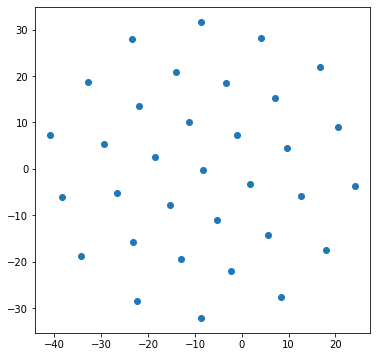

In [1274]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


doc_tags = np.unique(df["drug"])
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform([drug_to_doc_vec_dict[drug] for i, doc_tag in enumerate(doc_tags)])
df_tsne = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])

fig = plt.figure(figsize=(6,6))
plt.scatter(x=df_tsne["x"], y=df_tsne["y"])